<a href="https://colab.research.google.com/github/Bilal3099/Transfer-Learning/blob/main/Densenet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import scipy
import numpy as np
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from sklearn import metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, DenseNet201
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout,Dense,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
input_path = '/content/drive/MyDrive/archive/chest_xray/'
train_ds_path = input_path + 'train'
test_ds_path = input_path + 'test'
val_ds_path = input_path + 'val'

In [ ]:
img_size = 150
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


train_batch = train_datagen.flow_from_directory(
              train_ds_path,
              target_size = (img_size, img_size),
              batch_size = batch_size,
              shuffle=True,
              class_mode = 'binary'
)


val_batch = val_datagen.flow_from_directory(
            val_ds_path,
            target_size = (img_size, img_size),
            batch_size = batch_size,
            shuffle=False,
            class_mode = 'binary'
)

test_batch = test_datagen.flow_from_directory(
             test_ds_path,
             target_size = (img_size, img_size),
             batch_size = batch_size,
             shuffle=False,
             class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
imgs, label = next(train_batch)

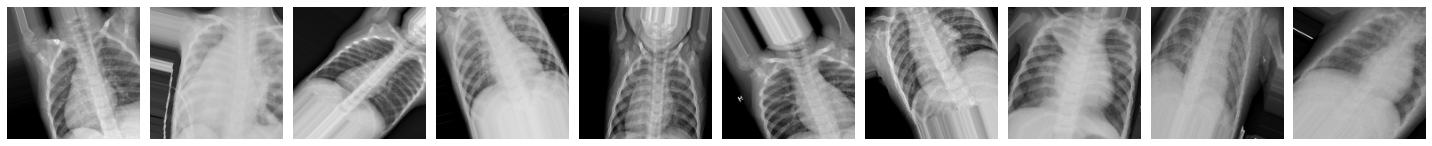

[0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 1. 1.]


In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip (images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()  

plotImages(imgs)
print(label)

In [ ]:
def build_model(backbone, learning_rate=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['acc']
    )
    return model
                
        
  

densenet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(densenet, learning_rate=1e-4)
model.summary()

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 1921      
                                                         

In [ ]:
history = model.fit(
    train_batch,
    steps_per_epoch=163,
    epochs=20,
    validation_data=test_batch,
    validation_steps=20
)

Epoch 1/20
163/163 [==============================] - 1261s 7s/step - loss: 0.2454 - acc: 0.9116 - val_loss: 0.2379 - val_acc: 0.9119
Epoch 2/20
163/163 [==============================] - 101s 616ms/step - loss: 0.1267 - acc: 0.9595 - val_loss: 0.6757 - val_acc: 0.6939
Epoch 3/20
163/163 [==============================] - 99s 608ms/step - loss: 0.0998 - acc: 0.9647 - val_loss: 0.2282 - val_acc: 0.9391
Epoch 4/20
163/163 [==============================] - 99s 607ms/step - loss: 0.1002 - acc: 0.9659 - val_loss: 0.8328 - val_acc: 0.7260
Epoch 5/20
163/163 [==============================] - 101s 616ms/step - loss: 0.0865 - acc: 0.9711 - val_loss: 0.2069 - val_acc: 0.9263
Epoch 6/20
163/163 [==============================] - 99s 606ms/step - loss: 0.0839 - acc: 0.9730 - val_loss: 0.2996 - val_acc: 0.9119
Epoch 7/20
163/163 [==============================] - 99s 608ms/step - loss: 0.0641 - acc: 0.9793 - val_loss: 0.5248 - val_acc: 0.8141
Epoch 8/20
163/163 [==============================] - 

In [ ]:

model.save('Densenet201Model.h5')

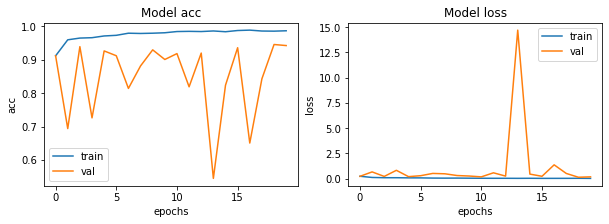

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [ ]:
pred = model.predict(val_batch)

1/1 [==============================] - 3s 3s/step


In [ ]:
pred

array([[3.2416746e-01],
       [2.5289221e-04],
       [2.8072679e-01],
       [2.4437541e-02],
       [2.5782853e-01],
       [7.7048993e-01],
       [1.6595277e-03],
       [7.8692048e-09],
       [9.9995112e-01],
       [9.9975544e-01],
       [9.3588537e-01],
       [9.8144352e-01],
       [9.9598807e-01],
       [9.9968171e-01],
       [9.9968529e-01],
       [9.9247462e-01]], dtype=float32)

In [ ]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)


In [ ]:
y_pred

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
y_true=val_batch.classes

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
cm = confusion_matrix(y_true, y_pred)

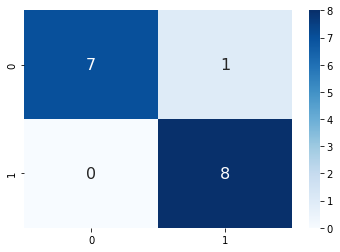

In [ ]:
import seaborn as sn
sn.heatmap(cm, annot=True,cmap="Blues", annot_kws={"size": 16})

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



ROC:  0.9375


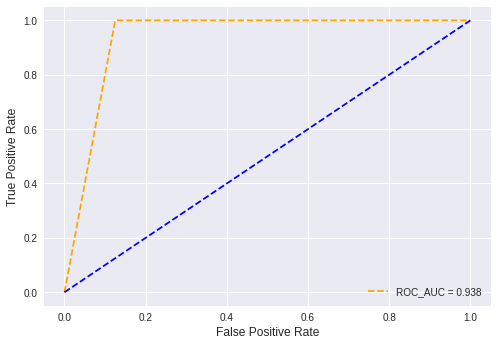

In [ ]:
roc_auc = metrics.roc_auc_score(y_true, y_pred)
print('ROC: ', roc_auc)

random_probs = [0 for i in range(len(y_true))]
p_fpr, t_fpr, thresholds = metrics.roc_curve(y_true, random_probs)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color='orange', label='ROC_AUC = %0.3f' % roc_auc)
plt.plot(p_fpr, t_fpr, linestyle = '--', color = 'blue')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc = 'lower right')

plt.show()



In [ ]:
def predict_image(model, img_path, img_dims = 150):
    img = image.load_img(img_path, target_size = (img_dims, img_dims))
    plt.imshow(img)
    plt.show()
    img = image.img_to_array(img)
    x = np.expand_dims(img, axis=0) * 1./255
    score = model.predict(x)
    print('Predictions: ', score, 'NORMAL' if score < 0.5 else 'PNEUMONIA')

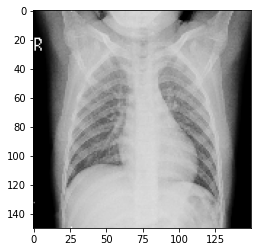

1/1 [==============================] - 4s 4s/step
Predictions:  [[0.01670022]] NORMAL


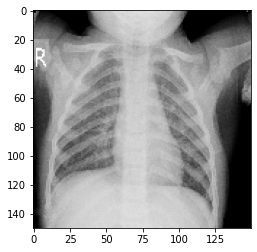

1/1 [==============================] - 0s 36ms/step
Predictions:  [[1.6708113e-05]] NORMAL


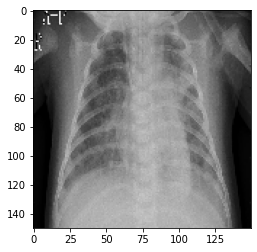

1/1 [==============================] - 0s 38ms/step
Predictions:  [[0.9999901]] PNEUMONIA


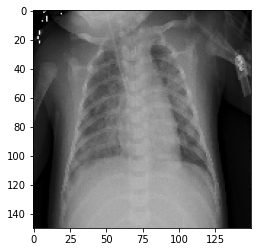

1/1 [==============================] - 0s 37ms/step
Predictions:  [[0.99968934]] PNEUMONIA


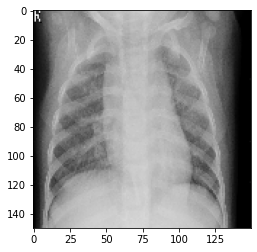

1/1 [==============================] - 0s 35ms/step
Predictions:  [[0.76019377]] PNEUMONIA


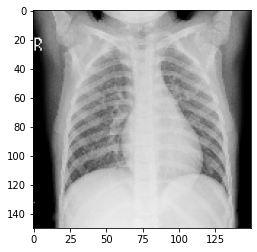

1/1 [==============================] - 0s 37ms/step
Predictions:  [[0.03852199]] NORMAL


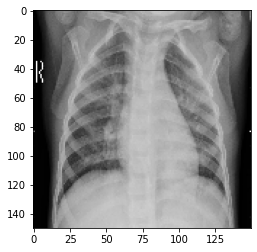

1/1 [==============================] - 0s 39ms/step
Predictions:  [[0.9987895]] PNEUMONIA


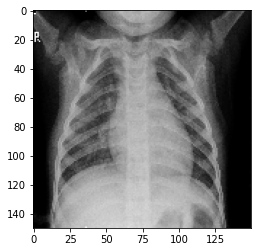

1/1 [==============================] - 0s 36ms/step
Predictions:  [[0.6578716]] PNEUMONIA


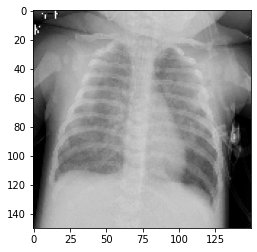

1/1 [==============================] - 0s 37ms/step
Predictions:  [[0.9957237]] PNEUMONIA


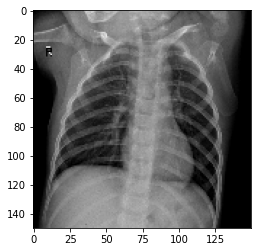

1/1 [==============================] - 0s 36ms/step
Predictions:  [[3.1285716e-09]] NORMAL


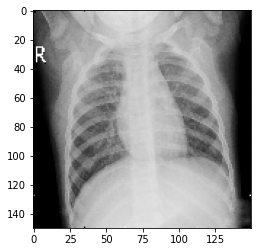

1/1 [==============================] - 0s 35ms/step
Predictions:  [[0.44663185]] NORMAL


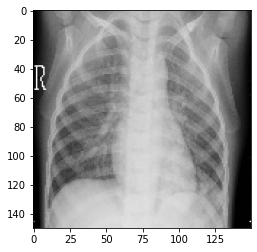

1/1 [==============================] - 0s 38ms/step
Predictions:  [[0.99967587]] PNEUMONIA


In [ ]:
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1427-0001.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1430-0001.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1946_bacteria_4874.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1946_bacteria_4875.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1947_bacteria_4876.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1431-0001.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1949_bacteria_4880.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1436-0001.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1952_bacteria_4883.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1442-0001.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1438-0001.jpeg'))
predict_image(model,(val_ds_path + '//PNEUMONIA/person1950_bacteria_4881.jpeg'))